<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.7
IPython 7.17.0

numpy 1.19.1
scipy 1.5.0
pandas 1.1.0
matplotlib 3.3.1
statsmodels 0.11.1
sklearn 0.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD
CPU cores  : 16
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score


In [4]:
PATH_TO_DATA = r'C:\Users\nspap\_jupiter_work'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_score_time'], grid_cv_results_['std_score_time']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [10]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(100)

In [13]:
%time 
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=skf)
knn_cv_scores.mean()

Wall time: 0 ns


0.5593373897012363

In [14]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [15]:
acc = accuracy_score(knn.predict(X_valid), y_valid)
acc

0.584024650391088

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [16]:
write_answer_to_file("{} {}".format(round(float(knn_cv_scores.mean()), 3), 
                                    round(acc, 3)),
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(100, random_state=17, oob_score=True).fit(X_train, y_train)

In [18]:
forest.oob_score_

0.7251574883153831

In [19]:
rf_acc = accuracy_score(forest.predict(X_valid), y_valid)
print(rf_acc)

0.7293197440151695


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [20]:
write_answer_to_file("{} {}".format(round(forest.oob_score_, 3), round(rf_acc, 3)),
                     'answer4_2.txt')

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [22]:
logit = LogisticRegression(random_state=17)
logit_cv_score = cross_val_score(logit, X_train, y_train, cv=skf)

In [23]:
logit_cv_score.mean()

0.7606189739891912

In [24]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=17)

In [28]:
logit_acc = accuracy_score(logit.predict(X_valid), y_valid)
logit_acc

0.7767243422611994

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [26]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(
    Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 16 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

In [27]:
accuracy_score(logit_grid_searcher1.predict(X_valid), y_valid)

0.7750651813225883

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [27]:
logit_mean_cv_scores1 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher1.scores_.items()]).mean(axis=0)
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76122864, 0.75787588, 0.75025516, 0.74039964])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [28]:
np.max(logit_mean_cv_scores1), logit_c_values1[np.argmax(logit_mean_cv_scores1)]

(0.7612286371644574, 1.0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

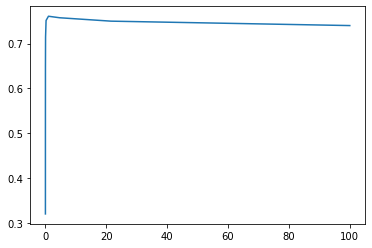

In [29]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [30]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(
    Cs=logit_c_values2, multi_class='multinomial', random_state=17, cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 43.1 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [31]:
logit_mean_cv_scores2 = np.array(
    [matr.mean(axis=0) for key, matr in logit_grid_searcher2.scores_.items()]).mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75919655, 0.76092382, 0.7608222 , 0.76122858,
       0.76133029, 0.76000937, 0.75929815, 0.75970453, 0.75909496,
       0.75919661, 0.75858698, 0.75767262, 0.75736787, 0.75706302,
       0.75635177, 0.75553904, 0.75513262, 0.7543198 , 0.7533037 ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
np.max(logit_mean_cv_scores2), logit_c_values2[np.argmax(logit_mean_cv_scores2)]

(0.761330294154816, 1.9157894736842107)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

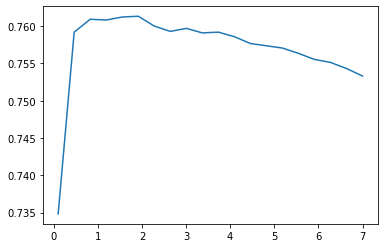

In [33]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [34]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7788575491822707

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
write_answer_to_file("{} {}".format(round(float(np.max(logit_mean_cv_scores2)), 3), 
                                    round(logit_cv_acc, 3)),
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [36]:
from sklearn.svm import LinearSVC

In [38]:
svm = LinearSVC(C=1, random_state=17).fit(X_valid, y_valid)

In [39]:
svm_cv_score = cross_val_score(svm, X_train, y_train, cv=skf)
svm_cv_score.mean()

0.7509671352428245

In [40]:
svm_cv_acc = accuracy_score(y_valid, svm.fit(X_train, y_train).predict(X_valid))
svm_cv_acc

0.7769613652524295

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [41]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 4s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [42]:
svm_grid_searcher1.best_params_

{'C': 4444.4445000000005}

In [43]:
svm_grid_searcher1.best_score_

0.6952843773612952

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

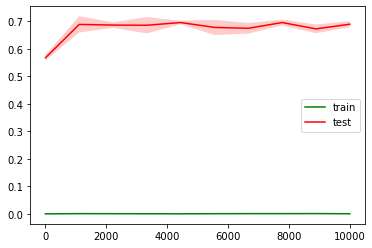

In [44]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [45]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 51s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [46]:
print(svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_)

{'C': 0.10434482758620689} 0.7701686093803548


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

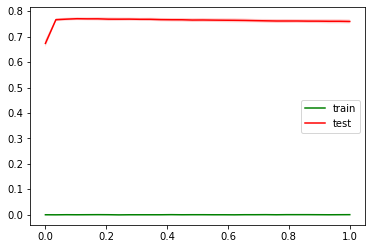

In [47]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [48]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
write_answer_to_file("{} {}".format(round(svm_grid_searcher2.best_score_, 3), 
                                    round(svm_cv_acc, 3)),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [29]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    

    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse_users = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_users_pkl:
        y_users = pickle.load(y_users_pkl)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sparse_users, y_users, random_state=random_state, test_size=test_size, stratify=y_users)
    model = estimator.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv))
    acc = accuracy_score(y_test, model.predict(X_test))
    return cv_score, acc

**Убедитесь, что функция работает.**

In [51]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s10_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s10_w10.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [54]:
%%time
estimator = svm_grid_searcher2.best_estimator_
results = []
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(
            PATH_TO_DATA, 'X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(
            PATH_TO_DATA, 'y_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv, acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print('window_size=', window_size, 'session_length=', session_length)
        print('cv_score=', cv, 'accuracy_score=', acc)
        results.append([window_size, session_length, cv, acc])

window_size= 10 session_length= 15
cv_score= 0.8243252292702751 accuracy_score= 0.8404835269021095
window_size= 10 session_length= 10
cv_score= 0.7670206386611259 accuracy_score= 0.7807537331121118
window_size= 7 session_length= 15
cv_score= 0.8495024256089474 accuracy_score= 0.8543222166915547
window_size= 7 session_length= 10
cv_score= 0.7983645917156946 accuracy_score= 0.8073668491786958
window_size= 7 session_length= 7
cv_score= 0.754765400423003 accuracy_score= 0.7617388418782147
window_size= 5 session_length= 15
cv_score= 0.8670355547005402 accuracy_score= 0.8752963489805595
window_size= 5 session_length= 10
cv_score= 0.8177520250854086 accuracy_score= 0.8245614035087719
window_size= 5 session_length= 7
cv_score= 0.772939529035208 accuracy_score= 0.7853247984826932
window_size= 5 session_length= 5
cv_score= 0.7254849424351582 accuracy_score= 0.7362494073020389
Wall time: 15.6 s


In [55]:
results

[[10, 15, 0.8243252292702751, 0.8404835269021095],
 [10, 10, 0.7670206386611259, 0.7807537331121118],
 [7, 15, 0.8495024256089474, 0.8543222166915547],
 [7, 10, 0.7983645917156946, 0.8073668491786958],
 [7, 7, 0.754765400423003, 0.7617388418782147],
 [5, 15, 0.8670355547005402, 0.8752963489805595],
 [5, 10, 0.8177520250854086, 0.8245614035087719],
 [5, 7, 0.772939529035208, 0.7853247984826932],
 [5, 5, 0.7254849424351582, 0.7362494073020389]]

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
write_answer_to_file("{} {}".format(round(results[5][2], 3), 
                                    round(results[5][3], 3)),
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [60]:
%%time
estimator = svm_grid_searcher2.best_estimator_
results = []
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(
            PATH_TO_DATA, 'X_sparse_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(
            PATH_TO_DATA, 'y_150users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        cv, acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print('session_length=', session_length, 'window_size=', window_size)
        print('cv_score=', cv, 'accuracy_score=', acc)
        results.append([session_length, window_size, cv, acc])

session_length= 15 window_size= 10
cv_score= 0.5488098589346596 accuracy_score= 0.5751471804602735
session_length= 10 window_size= 10
cv_score= 0.46307591254574465 accuracy_score= 0.4836276942538802
session_length= 15 window_size= 7
cv_score= 0.5834026774113491 accuracy_score= 0.6086282658309773
session_length= 10 window_size= 7
cv_score= 0.5017883472751427 accuracy_score= 0.5239295568348264
session_length= 7 window_size= 7
cv_score= 0.4366487102001489 accuracy_score= 0.45295840855673264
session_length= 15 window_size= 5
cv_score= 0.6140356366253149 accuracy_score= 0.635980921789069
session_length= 10 window_size= 5
cv_score= 0.5265397431284514 accuracy_score= 0.5459069450528058
session_length= 7 window_size= 5
cv_score= 0.46511167081227933 accuracy_score= 0.48184649827225384
session_length= 5 window_size= 5
cv_score= 0.4083611011164474 accuracy_score= 0.42171606560568453
Wall time: 31min 55s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [62]:
write_answer_to_file("{} {}".format(round(results[1][2], 3), 
                                    round(results[1][3], 3)),
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [63]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [64]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [104]:
logit_grid_searcher2.Cs_[10]

3.7315789473684213

In [105]:
%%time
logit_cv_150users = LogisticRegressionCV(
    Cs=[logit_grid_searcher2.Cs_[10]], random_state=17, multi_class='ovr', cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 6min 24s


LogisticRegressionCV(Cs=[3.7315789473684213],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [98]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 6, CV score: 0.9959755088254802
User 13, CV score: 0.9965593813941138
User 15, CV score: 0.9948912067443112
User 16, CV score: 0.9913046310026494
User 28, CV score: 0.9903662648597784
User 31, CV score: 0.9933898448308209
User 33, CV score: 0.9936817726904991
User 39, CV score: 0.9858830368939439
User 46, CV score: 0.9977792359106059
User 49, CV score: 0.9951101625584025
User 50, CV score: 0.9939841394927094
User 53, CV score: 0.9933794189328904
User 65, CV score: 0.9965176810635423
User 66, CV score: 0.9944637318845608
User 82, CV score: 0.9960797737835605
User 85, CV score: 0.9960380783447148
User 89, CV score: 0.9903349964059134
User 92, CV score: 0.9942135103342297
User 100, CV score: 0.9943698993467116
User 102, CV score: 0.9912733478736074
User 103, CV score: 0.980909772702
User 105, CV score: 0.9968513184937183
User 106, CV score: 0.9948390658406325
User 118, CV score: 0.9910856692097824
User 119, CV score: 0.9964029912945817
User 120, CV score: 0.9938381638770813
User 126,

In [103]:
logit_grid_searcher2.Cs_[10]

3.7315789473684213

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [112]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(
        logit_cv_150users.scores_[user_id].mean() - (class_distr.sum() - class_distr[user_id]) / class_distr.sum())

In [113]:
num_better_than_default = (np.array(list(acc_diff_vs_constant)) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [114]:
write_answer_to_file("{}".format(round(num_better_than_default/150.0, 3)),
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [129]:
y_binary_128 = (y_train_150 == 128).astype('int')

In [130]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [132]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 5.34 s


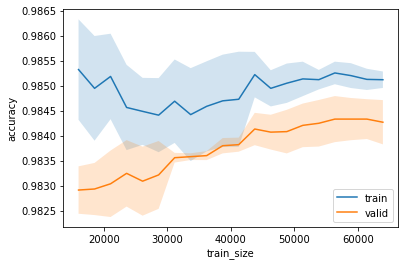

In [133]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.